In [1]:
import numpy as np
from IPython.display import Audio, clear_output
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
dataset = np.load("preprocess_data.npy")

In [2]:
dataset.shape

(17258, 256)

In [3]:
dataset = dataset[:3000]

In [4]:
dataset = (dataset/128).astype(np.float32)
dataset.shape

(3000, 256)

In [5]:
BATCH_SIZE = 128
train_dataset = tf.data.Dataset.from_tensor_slices(dataset).batch(BATCH_SIZE,drop_remainder=True)
train_dataset

<BatchDataset shapes: (128, 256), types: tf.float32>

In [6]:
from math import sqrt
seq_len = 256
gen_len = int(sqrt(seq_len))

In [7]:
def WaveGANGenerator():
    model = tf.keras.Sequential([
        Dense(seq_len,  activation='relu',input_shape=(seq_len,)),
        Reshape((1,seq_len)),
        
        Conv1D(64, kernel_size=25, strides=4, padding="same"),
        BatchNormalization(momentum=0.8),
        ReLU(),
        
        Conv1D(128,kernel_size=25, strides=4,padding='same'),
        BatchNormalization(momentum=0.8),
        ReLU(),
        
        Conv1D(seq_len,kernel_size=25,strides=4, padding='same'),
        BatchNormalization(momentum=0.8),
        ReLU(),
        
        Conv1D(seq_len,kernel_size=25,strides=4, padding='same'),
        BatchNormalization(momentum=0.8),
        ReLU(),
        
        Flatten(),
        Dense(seq_len, activation='sigmoid')
    ])
    return model

In [8]:
generator = WaveGANGenerator()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               65792     
_________________________________________________________________
reshape (Reshape)            (None, 1, 256)            0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 64)             409664    
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 64)             256       
_________________________________________________________________
re_lu (ReLU)                 (None, 1, 64)             0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1, 128)            204928    
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 128)            5

In [9]:
def WaveGANDiscriminator():
    model = tf.keras.Sequential([
        
        Dense(seq_len,  activation='relu',input_shape=(seq_len,)),
        Reshape((1,seq_len)),
        
        Conv1D(64, kernel_size=25, strides=4, padding="same"),
        BatchNormalization(momentum=0.8),
        ReLU(),
    
        Conv1D(seq_len,kernel_size=25,strides=4, padding='same'),
        BatchNormalization(momentum=0.8),
        ReLU(),
        
        Conv1D(seq_len,kernel_size=25,strides=4, padding='same'),
        BatchNormalization(momentum=0.8),
        ReLU(),
        
        Flatten(),
        Dense(seq_len, activation='sigmoid')
        ])
    return model

In [10]:
discriminator=  WaveGANDiscriminator()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
reshape_1 (Reshape)          (None, 1, 256)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 1, 64)             409664    
_________________________________________________________________
batch_normalization_4 (Batch (None, 1, 64)             256       
_________________________________________________________________
re_lu_4 (ReLU)               (None, 1, 64)             0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 1, 256)            409856    
_________________________________________________________________
batch_normalization_5 (Batch (None, 1, 256)           

In [11]:
## DCGAN

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


In [12]:
@tf.function
def train_step(music):
    LAMBDA = 10
    noise = tf.random.normal([BATCH_SIZE,seq_len])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        
        generated_music = generator(noise, training=True)
        real_output = discriminator(music, training=True)
        fake_output = discriminator(generated_music, training=True)
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(fake_output,real_output)       

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss,disc_loss

In [13]:
import time
total_Gloss = []
total_Dloss = []
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()
        G_loss = 0
        D_loss = 0
        for i,image_batch in enumerate(dataset):
            gen_loss,disc_loss = train_step(image_batch)
            print(f"Step：{i} | G_loss：{gen_loss} D_loss：{disc_loss}|")
            G_loss += gen_loss
            D_loss += disc_loss
        clear_output(wait=True)
        print (f'Time for epoch {epoch + 1} is {time.time()-start} sec\n')
        print(f'G_AVE_Loss：{G_loss/len(dataset)}')
        print(f'D_AVE_loss：{D_loss/len(dataset)}')
        total_Gloss.append(G_loss/len(dataset))
        total_Dloss.append(D_loss/len(dataset))

In [14]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [15]:
train(train_dataset, 100)

Time for epoch 4 is 19.168875217437744 sec

G_AVE_Loss：0.7063077092170715
D_AVE_loss：1.3727275133132935
Step：0 | G_loss：0.7022656202316284 D_loss：1.3465490341186523|
Step：1 | G_loss：0.694482684135437 D_loss：1.33878493309021|
Step：2 | G_loss：0.711487889289856 D_loss：1.3579185009002686|
Step：3 | G_loss：0.6897322535514832 D_loss：1.3274164199829102|
Step：4 | G_loss：0.7002146244049072 D_loss：1.3402560949325562|
Step：5 | G_loss：0.6995708346366882 D_loss：1.3373827934265137|
Step：6 | G_loss：0.7031548023223877 D_loss：1.3386937379837036|
Step：7 | G_loss：0.7019153833389282 D_loss：1.3361603021621704|
Step：8 | G_loss：0.697178304195404 D_loss：1.324415922164917|
Step：9 | G_loss：0.6968964338302612 D_loss：1.3245368003845215|
Step：10 | G_loss：0.6897846460342407 D_loss：1.3165645599365234|
Step：11 | G_loss：0.6908230185508728 D_loss：1.319263219833374|
Step：12 | G_loss：0.6874436140060425 D_loss：1.308453917503357|
Step：13 | G_loss：0.6899881362915039 D_loss：1.3133974075317383|
Step：14 | G_loss：0.6820655465126

KeyboardInterrupt: 

In [ ]:
import random
from mido import MidiFile, MidiTrack, Message
noise =   np.random.normal(0,1,(1,seq_len))
predict = generator.predict(noise)
predict = predict*127

In [ ]:
max(predict[0])

In [ ]:
midler = MidiFile()
track = MidiTrack()
midler.tracks.append(track)

track.append(Message('program_change', program=2, time=0))
for x in range(seq_len):
    on_interval = random.randint(0,127)
    off_interval = random.randint(0,127)
    change_interval = random.randint(0,127)
    change_value = random.randint(0,127)
    isControl = random.randint(0,1)
    track.append(Message('note_on',channel =1, note=int(predict[0][x]), velocity=64, time = on_interval)) 
    if isControl:
         track.append(Message('control_change',channel =1, control=64, value=change_value, time = change_interval)) 
    track.append(Message('note_off',channel =1 ,note=int(predict[0][x]), velocity=64, time = off_interval))
    midler.save('WaveGan.mid')

In [ ]:
np.save('0612_wavengan_gloss.npy', np.array(total_Gloss))
np.save('0612_wavengan_dis_dloss.npy',np.array(total_Dloss ))

In [2]:
import numpy as np
np.load('0612_wavengan_gloss.npy')
np.load('0612_wavengan_dis_dloss.npy')

array([1.4776595 , 1.4487407 , 1.4299046 , 1.4135332 , 1.3989254 ,
       1.3801223 , 1.3507127 , 1.3000921 , 1.2238885 , 1.1431016 ,
       1.0495695 , 0.95805186, 0.8750216 , 0.7979662 , 0.7287936 ,
       0.67089903, 0.6162987 , 0.55574286, 0.52047896, 0.45952192,
       0.43803957, 0.40448678, 0.36714604, 0.33876175, 0.31125563,
       0.29856473, 0.27447128, 0.25578004, 0.23886243, 0.23154959,
       0.22238016, 0.19697061, 0.18751027, 0.17610978, 0.16376483,
       0.15811063, 0.14191136, 0.13599478, 0.1465556 , 0.13182703,
       0.1252712 , 0.11220514, 0.10398987, 0.10409389, 0.09507309,
       0.09335051, 0.08579105, 0.09893492, 0.09109709, 0.08050581,
       0.07830118, 0.07456189, 0.07194372, 0.0665047 , 0.06447583,
       0.06629994, 0.05993115, 0.05583855, 0.05334733, 0.04988665,
       0.0474213 , 0.04645086, 0.04563548, 0.04313833, 0.04220815,
       0.04007551, 0.03865317, 0.03767962, 0.0358358 , 0.03519069,
       0.0348844 , 0.03148047, 0.03152269, 0.03046593, 0.02986

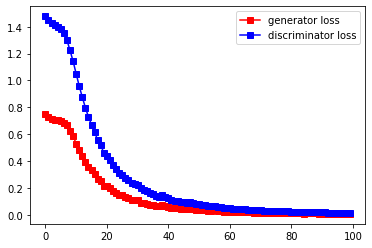

In [3]:
import matplotlib.pyplot as plt
g = np.load('0612_wavengan_gloss.npy')
month = [i for i in range(len(g))]
plt.plot(g,'s-',color = 'r', label="generator loss")
d=np.load('0612_wavengan_dis_dloss.npy')
plt.plot(d,'s-',color = 'b', label="discriminator loss")
plt.legend(loc = "best", fontsize=10)
plt.show()